In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import joypy
from matplotlib import cm
import matplotlib as mpl
import numpy as np
import scipy.stats as st
import squarify
mpl.rcParams['pdf.fonttype'] = 42

centimeter = 1/2.54


In [2]:
color_palette = {
    'White' : '#ffffb3',
    'Asian' : '#fb8072',
    'M. Eastern' : '#80b1d3',
    'Latinx' : '#fdb462',
    'Indian' : '#b3de69',
    'Black' : '#fccde5',
    'Male' : '#bebada',
    'Female' : '#8dd3c7'
}


In [3]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.986

In [4]:
covers = pd.read_csv('../../data/vogue_data/cover_ethnicity.csv')
ethnicity_map = {
    6: 'White',
    5: 'Asian',
    4: 'M. Eastern',
    3: 'Latinx',
    2: 'Indian',
    1: 'Asian',
    0: 'Black'
}

covers['ethnicity'] = covers['predicted_ethnicity'].apply(lambda x: ethnicity_map[x])
covers.head()

,image_source,year,predicted_ethnicity,ethnicity
0,Apr.jpg_0.jpg,1970,6,White
1,Aug.jpg_0.jpg,1970,6,White
2,Dec.jpg_0.jpg,1970,6,White
3,Feb.jpg_0.jpg,1970,6,White
4,Jan.jpg_0.jpg,1970,6,White


In [6]:
age_df = pd.concat([pd.read_csv('../../data/vogue_data/USA_DOB1.csv'), pd.read_csv('../../data/vogue_data/USA_DOB2.csv')])
age_df = age_df[['year', 'date_of_birth']]
age_df = age_df.dropna()
age_df['age'] = age_df['year'] - age_df['date_of_birth']
age_df['decade'] = age_df['year'].apply(lambda x: str(int(x/10) * 10) + 's')
age_df.head()

,year,date_of_birth,age,decade
0,1970,1946.0,24.0,1970s
4,1970,1939.0,31.0,1970s
5,1970,1943.0,27.0,1970s
6,1970,1942.0,28.0,1970s
7,1970,1943.0,27.0,1970s


In [7]:

def adjust_zeros(df):
    ethnicities = list(df['ethnicity'].unique())
    for year in df['year'].unique():
        sliced = df[df['year'] == year]
        for eth in ethnicities:
            if eth not in sliced['ethnicity'].unique():
                temp = pd.DataFrame({'year' : [year], 'ethnicity' : [eth], 'percentage' : [0]})
                df = pd.concat([df, temp])
    
    return df


def adjust_countries(df):
    countries = list(df['country'].unique())
    percentages = []
    for country in countries:
        sliced = df[df['country'] == country]
        percentages.append(len(sliced.loc[sliced['ethnicity'] == 'White']) * 100 / len(sliced))
        
    return_df = pd.DataFrame({'country' : countries, 'percentage' : percentages})
    return_df.to_csv('./data/country_white_percentages.csv', index = False)
    return return_df
    

def plot_cover_ethnicity_temporal(covers, ax):
    grouped = covers.groupby(by = ['year'])['ethnicity'].value_counts(normalize = True).reset_index(name = 'percentage')
    grouped['percentage'] = grouped['percentage'] * 100
    grouped = adjust_zeros(grouped)
    sns.lineplot(data = grouped, x = 'year', y = 'percentage', hue = 'ethnicity', ax = ax, legend=False, palette=color_palette)
    # sns.scatterplot(data = grouped, x = 'year', y = 'percentage', hue = 'ethnicity', ax = ax, legend=False, s = 10, palette=color_palette)
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Percentage of cover models', fontsize=8)
    ax.add_patch(plt.Rectangle((2008, 0), 16, 40, linestyle = 'dashed', facecolor = 'None', edgecolor = 'black', linewidth = 1, alpha = 0.5))
    
    custom_lines = []
    
    for key in color_palette.keys():
        custom_lines.append(Line2D([0], [0], color=color_palette[key], lw=2))
    
    ax.legend(custom_lines, list(color_palette.keys()), loc='center', bbox_to_anchor=(0.3, 0.5), fontsize = 6, ncol=3)
    
    
def plot_cover_ethnicity_zoomed(covers, ax_black, ax_asian, ax_middle, ax_indian, ax_latino):
    order = ['Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']
    grouped = covers.groupby(by = ['year'])['ethnicity'].value_counts(normalize = True).reset_index(name = 'percentage')
    grouped['percentage'] = grouped['percentage'] * 100
    grouped = adjust_zeros(grouped)
    grouped = grouped[grouped['year'] >= 2008]
    for i, eth_ax in enumerate(zip(order, [ax_black, ax_asian, ax_middle, ax_indian, ax_latino])):
        eth = eth_ax[0]
        ax = eth_ax[1]
        grouped_eth = grouped[grouped['ethnicity'] == eth]
        sns.lineplot(data = grouped_eth, x = 'year', y = 'percentage', hue = 'ethnicity', ax = ax, alpha = 0.75, legend=False, palette=color_palette)
        sns.scatterplot(data = grouped_eth, x = 'year', y = 'percentage', hue = 'ethnicity', ax = ax, legend=False, alpha = 0.75, s = 10, palette=color_palette)
    
        
        if i == 4:
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel('')
            ax.set_xticks([2010, 2020])
            ax.set_xticklabels([2010, 2020], fontsize = 8)
            
        else:
            ax.set_xlabel('', fontsize=8)
            ax.set_ylabel('', fontsize=8)
            ax.set_xticklabels([])
    

    
def get_colors(country_data, colors):
    d = {}
    
    for i, row in country_data.iterrows():
        if row['country'] in ['Netherlands', 'UK', 'Germany', 'Italy', 'France', 'Russia', 'Ukraine', 'USA', 'Australia']:
            d[row['country']] = colors[0]
        elif row['country'] in ['India', 'Japan', 'South Korea', 'Thailand', 'Arabia', 'China', 'Taiwan', 'Portugal', 'Spain', 'Turkey', 'Mexico','Brazil']:
            d[row['country']] =  colors[1]
            
    return d
        
    
def plot_international_ethnicity(country_data, ax, orientation = None):
    
    colors = ['tab:blue', 'tab:red']
    country_data = country_data.sort_values(by = ['percentage'], ascending = False)
    if orientation == None:
        
        f = sns.barplot(data = country_data, x = 'country', y = 'percentage', ax = ax, palette = get_colors(country_data, colors), alpha = 0.6)
        f.set_ylabel('Proportion of white models', fontsize=8)
        f.set_xlabel('', fontsize=8)
        f.set_xticklabels(f.get_xticklabels(), rotation=90)
        
        
        # custom_lines = [Line2D([0], [0], color=colors[0], lw=2), Line2D([0], [0], color=colors[1], lw=2), Line2D([0], [0], color=colors[2], lw=2), Line2D([0], [0], color=colors[3], lw=2)]
        
        # ax.legend(custom_lines, ['Europe', 'Asia & Oceania', 'Latin America', 'USA'], loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize = 6, ncol = 4)
        
        custom_lines = [Line2D([0], [0], color=colors[0], lw=2), Line2D([0], [0], color=colors[1], lw=2)]
        
        ax.legend(custom_lines, ['White Majority', 'Non-White Majority'], loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize = 6, ncol = 4)
        ax.set_xticklabels(country_data['country'], rotation=45, fontsize = 8, ha = 'right',rotation_mode="anchor")
    
    else:
        f = sns.barplot(data = country_data, y = 'country', x = 'percentage', ax = ax, palette = get_colors(country_data, colors), alpha = 1)
        f.set_xlabel('Proportion of white models', fontsize=8)
        f.set_ylabel('', fontsize=8)
        f.set_yticklabels(f.get_yticklabels())
    


def plot_age_distribtutions(age_df):
    
    age_df = age_df[['age', 'decade']]
    fig, axs = joypy.joyplot(age_df, by='decade', alpha=0.75, linewidth=0.5, overlap = 0.25,\
        ylim = 'own', color = 'lightgrey', xlabelsize = 8, ylabelsize = 8, legend = False, \
        x_range = (10, 50), figsize = (8.5*centimeter, 6*centimeter))
    
    for ax, decade in zip(axs, ['1970s', '1980s', '1990s', '2000s', '2010s', '2020s']):
        print(decade, age_df[age_df['decade'] == decade]['age'].mean())
        print(decade, age_df[age_df['decade'] == decade]['age'].median())
        ax.vlines(x = age_df[age_df['decade'] == decade]['age'].mean(), ymin = 0, ymax = 0.075, color = 'black', linestyle = 'dashed', linewidth = 1, zorder = 10)
    
    
    plt.xlabel('Age', fontsize = 8)
    plt.ylabel('Decade', fontsize = 8)
    # plt.xlim((0, 80))
    
    # fig.savefig('../figures/model_age_distributions_vertical_gray.pdf', dpi = 300, bbox_inches = 'tight')
    
    

In [8]:
def plot_stacked_bars(covers, ax):
    
    grouped = covers.groupby(by = ['year'])['ethnicity'].value_counts(normalize = True).reset_index(name = 'percentage')
    grouped['percentage'] = grouped['percentage'] * 100
    grouped = adjust_zeros(grouped)
    grouped = grouped.sort_values(by = 'year')
    
    # print(grouped.head())
    
    num_years = len(grouped['year'].unique())
    width = 1
    bottom = [0] * num_years
    
    percentage_counts = {
        'Asian' : grouped.loc[grouped['ethnicity'] == 'Asian']['percentage'].tolist(),
        'M. Eastern' : grouped.loc[grouped['ethnicity'] == 'M. Eastern']['percentage'].tolist(),
        'Latinx' : grouped.loc[grouped['ethnicity'] == 'Latinx']['percentage'].tolist(),
        'Indian' : grouped.loc[grouped['ethnicity'] == 'Indian']['percentage'].tolist(),
        'Black' : grouped.loc[grouped['ethnicity'] == 'Black']['percentage'].tolist(),
        'White' : grouped.loc[grouped['ethnicity'] == 'White']['percentage'].tolist()
    }
    
    
    for boolean, percentage_counts in percentage_counts.items():
        ax.bar(grouped['year'].unique(), percentage_counts, width, bottom = bottom, color = color_palette[boolean], label = boolean, edgecolor = '#adadad', linewidth = 0.15, alpha = 0.75)
        bottom = [sum(x) for x in zip(bottom, percentage_counts)]


Text(0, 0.5, 'Percentage of\ncover models')

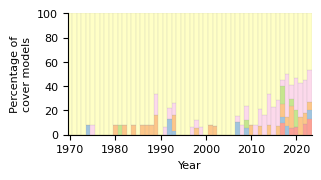

In [9]:
axd = plt.figure(figsize = (8*centimeter, 4*centimeter)).subplot_mosaic(
    """
    A
    """
)

plot_stacked_bars(covers, axd['A'])

axd['A'].tick_params(axis='both', which='major', labelsize=8)
axd['A'].spines['top'].set_visible(False)
axd['A'].spines['right'].set_visible(False)
axd['A'].set_xlim((1969.5, 2023.5))
axd['A'].set_ylim((0, 100))
axd['A'].set_xlabel('Year', fontsize = 8)
axd['A'].set_ylabel('Percentage of\ncover models', fontsize = 8)

# plt.savefig('../figures/vogue_cover_stacked_with_white_v2.pdf', bbox_inches = 'tight', dpi = 300)

In [10]:
houses = pd.read_csv('../../data/vogue_data/houses_ethnicity.csv')
ethnicity_map = {
    6: 'White',
    5: 'Asian',
    4: 'M. Eastern',
    3: 'Latinx',
    2: 'Indian',
    1: 'Asian',
    0: 'Black'
}

houses['ethnicity'] = houses['y_pred'].apply(lambda x: ethnicity_map[x])
houses['decade'] = houses['year'].apply(lambda x: str(int(x/10) * 10) + 's')
houses.head()

,year,house,y_pred,num_pixels,ethnicity,decade
0,1970,Anne Klein & Co,6,36456,White,1970s
1,1970,Bergdorf Goodman & Co,6,21082,White,1970s
2,1970,Bergdorf Goodman & Co,6,27676,White,1970s
3,1970,Bergdorf Goodman & Co,6,5208,White,1970s
4,1970,Bill Blass,6,894621,White,1970s


Asian 54
M. Eastern 54
Latinx 54
Indian 54
Black 54
White 54
{'Asian': [0.017054155392183887, 0.10242918142985738, 0.5480296288114623, 0.0, 0.05857383222356516, 0.0, 0.0, 0.2126632572017866, 0.039854692152569274, 0.01375027795302642, 0.13307128526389062, 0.0, 0.031667301981777744, 0.20826935033475502, 0.14093994449332276, 0.2637641000429441, 0.5638994386546753, 1.6026012031537153, 0.6173214759484311, 0.059624192240198465, 0.6404996327495127, 0.08302493194150026, 0.11237143360032485, 1.2682819054440413, 0.6133532387998719, 0.7588626817730856, 0.481440928085901, 1.5516382320937736, 1.5428178851883725, 1.1186640081445896, 6.148618666100476, 3.6186286840497477, 1.928654879510607, 0.5477923996095522, 1.4342803802251316, 0.3058636587644757, 0.698922567248499, 1.90291564005799, 1.9259203688705113, 0.8326241792419111, 1.3640442373485289, 1.4860718741757808, 1.4645785921926577, 0.4175323840221742, 1.479608196517868, 2.4424916234452856, 1.2612672197609238, 7.435157935605267, 1.8556914913283866, 

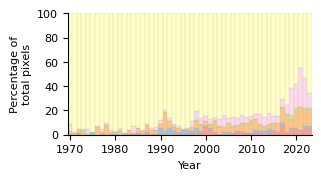

In [11]:
def plot_stacked_bars_pixels(houses, ax):
    grouped = houses.groupby(by = ['year', 'ethnicity']).agg({'num_pixels' : 'sum'}).reset_index()
    
    
    for year in grouped.year.unique():
        sliced = grouped[grouped['year'] == year]
        total = sliced['num_pixels'].sum()
        grouped.loc[grouped['year'] == year, 'percentage'] = (sliced['num_pixels'] / total) * 100
    
    grouped = adjust_zeros(grouped)
    grouped = grouped.sort_values(by = 'year')
    
    # print(grouped.head())
    
    num_years = len(grouped['year'].unique())
    width = 1
    bottom = [0] * num_years
    
    percentage_counts = {
        'Asian' : grouped.loc[grouped['ethnicity'] == 'Asian']['percentage'].tolist(),
        'M. Eastern' : grouped.loc[grouped['ethnicity'] == 'M. Eastern']['percentage'].tolist(),
        'Latinx' : grouped.loc[grouped['ethnicity'] == 'Latinx']['percentage'].tolist(),
        'Indian' : grouped.loc[grouped['ethnicity'] == 'Indian']['percentage'].tolist(),
        'Black' : grouped.loc[grouped['ethnicity'] == 'Black']['percentage'].tolist(),
        'White' : grouped.loc[grouped['ethnicity'] == 'White']['percentage'].tolist()
    }
    
    for key in percentage_counts:
        print(key, len(percentage_counts[key]))
        
    print(percentage_counts)
    for boolean, percentage_counts in percentage_counts.items():
        ax.bar(grouped['year'].unique(), percentage_counts, width, bottom = bottom, color = color_palette[boolean], label = boolean, edgecolor = '#adadad', linewidth = 0.15, alpha = 0.75)
        bottom = [sum(x) for x in zip(bottom, percentage_counts)]
    
    

axd = plt.figure(figsize = (8*centimeter, 4*centimeter)).subplot_mosaic(
    """
    A
    """
)


plot_stacked_bars_pixels(houses, axd['A'])

axd['A'].tick_params(axis='both', which='major', labelsize=8)
axd['A'].spines['top'].set_visible(False)
axd['A'].spines['right'].set_visible(False)
axd['A'].set_xlim((1969.5, 2023.5))
axd['A'].set_ylim((0, 100))
axd['A'].set_xlabel('Year', fontsize = 8)
axd['A'].set_ylabel('Percentage of\ntotal pixels', fontsize = 8)

# plt.savefig('../figures/total_pixels_houses_stacked_v2.pdf', bbox_inches = 'tight', dpi = 300)

Chanel 1970 Asian Series([], Name: percentage, dtype: float64)
Chanel 1970 M. Eastern Series([], Name: percentage, dtype: float64)
Chanel 1970 Latinx 1    3.921569
Name: percentage, dtype: float64
Chanel 1970 Indian Series([], Name: percentage, dtype: float64)
Chanel 1970 Black 2    0.980392
Name: percentage, dtype: float64
Chanel 1970 White 0    95.098039
Name: percentage, dtype: float64
Chanel 1980 Asian 4    2.1875
Name: percentage, dtype: float64
Chanel 1980 M. Eastern 3    2.5
Name: percentage, dtype: float64
Chanel 1980 Latinx 1    7.1875
Name: percentage, dtype: float64
Chanel 1980 Indian 5    0.625
Name: percentage, dtype: float64
Chanel 1980 Black 2    2.8125
Name: percentage, dtype: float64
Chanel 1980 White 0    84.6875
Name: percentage, dtype: float64
Chanel 1990 Asian 4    2.258065
Name: percentage, dtype: float64
Chanel 1990 M. Eastern 3    2.709677
Name: percentage, dtype: float64
Chanel 1990 Latinx 2    5.806452
Name: percentage, dtype: float64
Chanel 1990 Indian 5    0

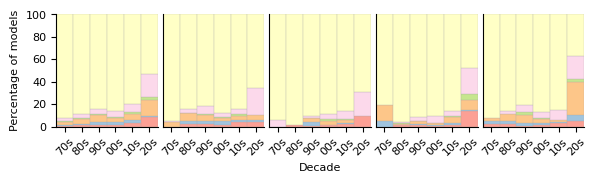

In [12]:
def plot_stacked_houses(axs, df, houses):
    
    ax = axs[0]
     
    df['decade_real'] = df['year'].apply(lambda x: int(x/10) * 10)
    for decade in df['decade_real'].unique():
        sliced_decade = df.loc[df['decade_real'] == decade]
        grouped = sliced_decade['ethnicity'].value_counts(normalize = True).reset_index(name = 'percentage').rename(columns = {'index' : 'ethnicity'})
        grouped['percentage'] = grouped['percentage'] * 100
        
        bottom = 0            
        for ethn in ['Asian', 'M. Eastern', 'Latinx', 'Indian', 'Black', 'White']:
            ax.bar(decade, grouped.loc[grouped['ethnicity'] == ethn]['percentage'], color = color_palette[ethn], alpha = 0.75, label = ethn, bottom = bottom, width = 10, edgecolor = '#adadad', linewidth = 0.25)
            try:
                bottom = bottom + grouped.loc[grouped['ethnicity'] == ethn]['percentage'].values[0]
            except:
                pass
        
    # ax.tick_params(axis='both', which='major', labelsize=8)
    
    for ax, house in zip(axs[1:], houses):
        sliced = df.loc[df['house'] == house]
        # sliced['decade_real'] = sliced['year'].apply(lambda x: int(x/10) * 10)
        
        for decade in sliced['decade_real'].unique():
            sliced_decade = sliced.loc[sliced['decade_real'] == decade]
            grouped = sliced_decade['ethnicity'].value_counts(normalize = True).reset_index(name = 'percentage').rename(columns = {'index' : 'ethnicity'})
            grouped['percentage'] = grouped['percentage'] * 100
        
            bottom = 0            
            for ethn in ['Asian', 'M. Eastern', 'Latinx', 'Indian', 'Black', 'White']:
                ax.bar(decade, grouped.loc[grouped['ethnicity'] == ethn]['percentage'], color = color_palette[ethn], alpha = 0.75, label = ethn, bottom = bottom, width = 10, edgecolor = '#adadad', linewidth = 0.25)
                print(house, decade, ethn, grouped.loc[grouped['ethnicity'] == ethn]['percentage'])
                try:
                    bottom = bottom + grouped.loc[grouped['ethnicity'] == ethn]['percentage'].values[0]
                except:
                    pass
                
        
    
    
    
    for i, ax in enumerate(axs):
        ax.set_xlim(1965, 2025)
        ax.set_ylim(0, 100)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
        ax.set_xticklabels(['70s', '80s', '90s', '00s', '10s', '20s'], fontsize = 8, rotation = 45)
        if i > 0:
            ax.set_yticks([])
        else:
            ax.set_ylabel('Percentage of models', fontsize = 8)
            
        if i == 2:
            ax.set_xlabel('Decade', fontsize = 8)
        
    sns.despine()
    return


cm = 1/2.54
fig, axs = plt.subplots(1, 5,figsize = (17.3*cm, 3.7*cm))

plot_stacked_houses(axs, houses, ['Chanel', 'Gucci', 'Ralph Lauren','Valentino'])

plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
# fig.savefig('../figures/houses_stacked_bars.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)


In [20]:
def get_colors(country_data, colors):
    d = {}
    
    for i, row in country_data.iterrows():
        if row['country'] in ['Netherlands', 'UK', 'Germany', 'Italy', 'France', 'Russia', 'Ukraine', 'USA', 'Australia']:
            d[row['country']] = colors[0]
        elif row['country'] in ['India', 'Japan', 'South Korea', 'Thailand', 'Arabia', 'China', 'Taiwan', 'Portugal', 'Spain', 'Turkey', 'Mexico','Brazil']:
            d[row['country']] =  colors[1]
            
    return d

def plot_international_ethnicity(country_data, ax, orientation = None):
    
    colors = ['#A9BCD0', '#1B1B1E']
    country_data = country_data.sort_values(by = ['percentage'], ascending = False)
    ax.set_xlim(-0.5, len(country_data) - 0.5)
    print(country_data.head())
    if orientation == None:
        
        for i, country in enumerate(country_data['country']):
            ax.bar(x = i, height = country_data.loc[country_data['country'] == country]['percentage'], color = color_palette['White'], alpha = 0.75, edgecolor = 'black', linewidth = 0.15)
            
        ax.set_ylabel('Proportion of white models', fontsize=8)
        ax.set_xlabel('', fontsize=8)
        ax.set_xticks([i for i in range(0, len(country_data))])
        ax.set_xticklabels([])
        sns.despine()

    
    else:
        f = sns.barplot(data = country_data, y = 'country', x = 'percentage', ax = ax, palette = get_colors(country_data, colors), alpha = 0.75)
        f.set_xlabel('Proportion of white models', fontsize=8)
        f.set_ylabel('', fontsize=8)
        f.set_yticklabels(f.get_yticklabels())

        country  percentage majority_white
0   Netherlands   96.825397           True
1         India   14.285714          False
2            UK   84.590164           True
3        Mexico   87.500000          False
4         Japan   86.206897          False
5       Germany   89.726027           True
6   South Korea   64.705882          False
7      Thailand   70.370370          False
8      Portugal   88.505747          False
9         Spain   87.830688          False
10        Italy   83.153348            NaN
11       Brazil   74.183007          False
12       Arabia   34.074074          False
13       Turkey   93.333333          False
14    Australia   88.177340           True
15        China   47.902098          False
16       France   87.951807           True
17       Russia   93.449782           True
18       Taiwan   10.000000          False
19          USA   79.876161           True
20      Ukraine   92.537313           True
13
21
        country  percentage majority_white
0   N

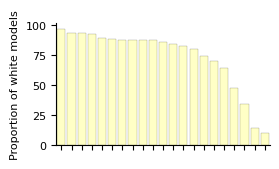

In [21]:
total_df = pd.read_csv('../../data/vogue_data/country_white_percentages.csv')
print(total_df.head(30))
total_df = total_df.sort_values(by ='percentage', ascending=False)
print(len(total_df[total_df['percentage'] > 80]))
print(len(total_df))

axd = plt.figure(figsize = (7*centimeter, 4*centimeter)).subplot_mosaic(
    """
    A
    """
)

plot_international_ethnicity(total_df, axd['A'])

axd['A'].tick_params(axis='x', which='major', pad = 2)
axd['A'].tick_params(axis='y', which='major', labelsize=8)
sns.despine()

# plt.savefig('../figures/country_white_percentages_v2.pdf', bbox_inches = 'tight', dpi = 300)


/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_48644/2166750647.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, y = 'num_pixels', x = 'ethnicity', ax = axs, palette = color_palette, order = order, showfliers = False, linewidth=0.5, showmeans = True, meanprops =
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_48644/2166750647.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation = 30)
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_48644/2166750647.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


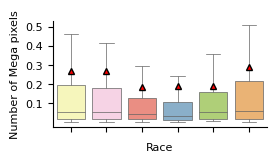

In [23]:
from statannot import add_stat_annotation

def plot_pixel_means_bars(df):
    df = df[['ethnicity', 'num_pixels']]
    order = ['White', 'Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']
    fig, axs = plt.subplots(1, 1, figsize = (7*centimeter, 3.5*centimeter))
    # sns.barplot(data = df, y = 'num_pixels', x = 'ethnicity', ax = axs, palette = color_palette, order = order, errwidth=1, alpha = 0.75)
    sns.boxplot(data = df, y = 'num_pixels', x = 'ethnicity', ax = axs, palette = color_palette, order = order, showfliers = False, linewidth=0.5, showmeans = True, meanprops = 
                {'marker':'^', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':5})
    
    
    axs.set_ylabel('Number of Mega pixels', fontsize = 8)
    axs.set_xlabel('Race', fontsize = 8)
    
    axs.set_xticklabels(axs.get_xticklabels(), rotation = 30)
    axs.set_yticks([100000, 200000, 300000, 400000, 500000])
    axs.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'], fontsize = 8)
    
    axs.tick_params(axis='both', which='major', labelsize=8)
    sns.despine()
    
    fig.show()
    
    # fig.savefig('../figures/num_pixels_bars.pdf', dpi = 300, bbox_inches = 'tight')
    
plot_pixel_means_bars(houses)